In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
import time
import os
import sys
import mat73
from torchsummary import summary


In [3]:
# absolute path for the project root directory
PROJECT_ROOT = r'c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression'

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify the path settings
print("Current working directory:", os.getcwd())
print("Project root directory:", PROJECT_ROOT)
print("Python path:", sys.path)

expected_dirs = ['src', 'datasets', 'notebooks', 'outputs', 'configs']
for dir_name in expected_dirs:
    dir_path = os.path.join(PROJECT_ROOT, dir_name)
    print(f"'{dir_name}' directory exists:", os.path.exists(dir_path))

# change to root dir
os.chdir(PROJECT_ROOT)
print("\nNew working directory:", os.getcwd())

Current working directory: c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression\notebooks
Project root directory: c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression
Python path: ['c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311', '', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages', 'c:\\Users\\WangCo\\Documents\\ProgramData\\Python\\radar_interference_

In [52]:
import importlib
from src.utils import analysis
from src.utils import training_validation
from src.utils import evaluation
from src.data import data_utils
from src.utils import visualization
from src.data.dataset import RadarDataset
from src.models import dualpath_autoencoder
from src.models import baseline_tec

In [55]:
# # reload the modules with the latest changes
importlib.reload(data_utils)
importlib.reload(visualization)
importlib.reload(analysis)
importlib.reload(training_validation)
importlib.reload(evaluation)
importlib.reload(dualpath_autoencoder)
importlib.reload(dualpath_autoencoder)

print("Modules reloaded successfully!")

Modules reloaded successfully!


In [ ]:
# # Data loading: define paths to your scenario files

# scenario_files = [
#     'datasets/raw/train_dataset_3t1.mat',
#     'datasets/raw/train_dataset_3t2.mat',
#     'datasets/raw/train_dataset_3t3.mat',
#     'datasets/raw/train_dataset_3t4.mat',
#     'datasets/raw/train_dataset_3t5.mat',
#     'datasets/raw/train_dataset_3t6.mat'
# ]

scenario_files = [
    os.path.join(PROJECT_ROOT, 'datasets', 'raw', 'test_dataset_2t1_60f.mat')  
]

print("Loading scenario data...")
radar_cube, clean_data, scenario_info = data_utils.load_multiple_scenarios(scenario_files)

# DEBUG INFO
print(f"Input shapes - radar_cube: {radar_cube.shape}, clean_data: {clean_data.shape}")
print(f"Data types - radar_cube: {radar_cube.dtype}, clean_data: {clean_data.dtype}")


Loading scenario data...

Scenario 1 loaded:
Shape: (256, 128, 60)
Number of frames: 60
[{'scenario_id': 1, 'num_frames': 60, 'shape': (256, 128, 60)}]
Input shapes - radar_cube: (256, 128, 60), clean_data: (256, 128, 60)
Data types - radar_cube: complex128, clean_data: complex128

Data statistics:
Radar cube - Mean amplitude: 0.132
Radar cube - Max amplitude: 0.247
Clean data - Mean amplitude: 0.129
Clean data - Max amplitude: 0.198


Analyzing original data...

Analyzing Range-Doppler Processing...

Peak Analysis:
Doppler peaks:
Velocity: 23.21 m/s
Velocity: 45.93 m/s

Range peaks:
Range: 17.75 m
Range: 20.50 m


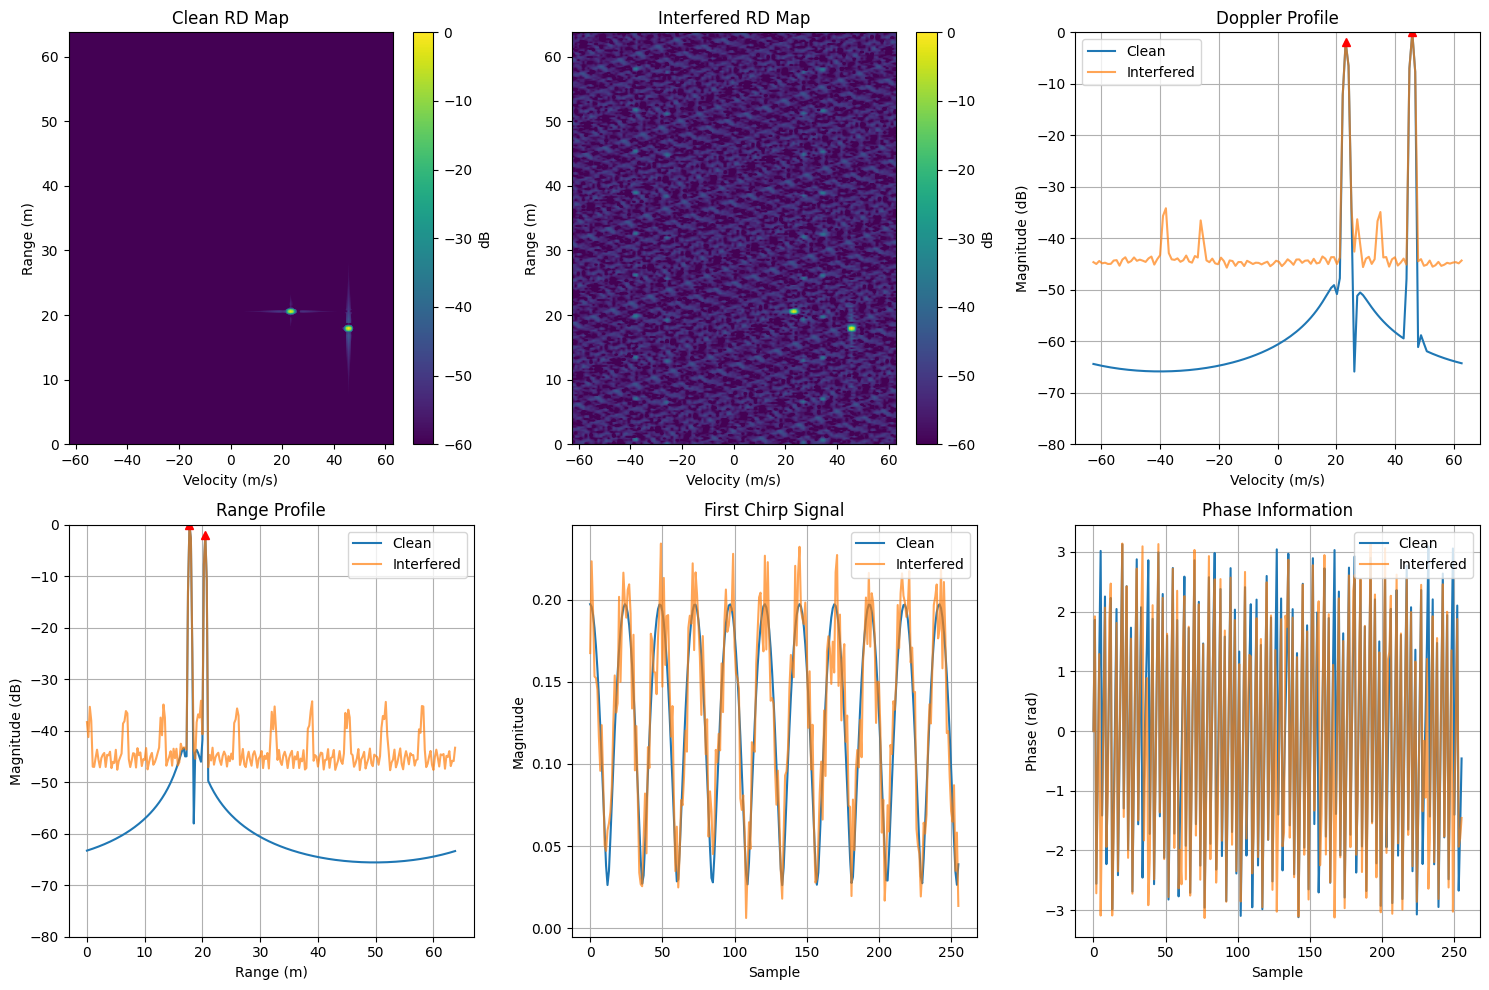

In [37]:
# analyze original data
print("Analyzing original data...")
analysis.analyze_rd_processing(radar_cube, clean_data)



In [38]:
# Data preparation
full_dataset = RadarDataset(radar_cube, clean_data)
val_size = int(len(full_dataset) * 0.2)
print(f"size of validation: {val_size}")
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

complex_to_real() triggered:
Real part range: [-0.246, 0.246]
Imag part range: [-0.246, 0.246]
complex_to_real() triggered:
Real part range: [-0.198, 0.198]
Imag part range: [-0.198, 0.198]
Dataset shapes after processing:
Interference data shape: (2, 256, 128, 60)
Clean data shape: (2, 256, 128, 60)
Number of frames: 60
size of validation: 12


In [47]:
# Training preparation
""""""""" For dual-path autoencoder usage """""""""
print("Initializing model......")
num_samples, num_chirps = radar_cube.shape[0:2]
# model = dualpath_autoencoder.DualPathRadarAutoencoder(num_samples=num_samples, num_chirps=num_chirps)
# model = dualpath_autoencoder.DualPathRadarAutoencoder_V2(num_samples=num_samples, num_chirps=num_chirps)
# model = dualpath_autoencoder.DualPathRadarAutoencoder_v3_2(num_samples=num_samples, num_chirps=num_chirps)
model = dualpath_autoencoder.DualPathRadarAutoencoder_v3_3(num_samples=num_samples, num_chirps=num_chirps)

""""""""" For dual-path autoencoder usage """""""""

# Create dummy inputs for both paths
batch_size = 4
summary_size = [
    (batch_size, 2, 256, 128),  # Raw signal input: [batch, channels, samples, chirps]
    (batch_size, 2, 256, 128)   # RD map input: [batch, channels, samples, chirps]
]
print(f"Summary input shapes: {summary_size}")
summary(model, summary_size)

Initializing model......
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 128]             304
         LeakyReLU-2         [-1, 16, 256, 128]               0
            Conv2d-3         [-1, 16, 256, 128]           2,320
         LeakyReLU-4         [-1, 16, 256, 128]               0
         MaxPool2d-5          [-1, 16, 128, 64]               0
            Conv2d-6          [-1, 32, 128, 64]           4,640
         LeakyReLU-7          [-1, 32, 128, 64]               0
            Conv2d-8          [-1, 32, 128, 64]           9,248
         LeakyReLU-9          [-1, 32, 128, 64]               0
        MaxPool2d-10           [-1, 32, 64, 32]               0
           Conv2d-11           [-1, 64, 64, 32]          18,496
        LeakyReLU-12           [-1, 64, 64, 32]               0
           Conv2d-13           [-1, 64, 64, 32]          36,928
        LeakyR

In [8]:
# Check
relative_path = 'outputs/models'
absolute_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'outputs', 'models'))
print(f"Relative path exists: {os.path.exists(relative_path)}")
print(f"Absolute path exists: {os.path.exists(absolute_path)}")

Relative path exists: True
Absolute path exists: False


In [48]:
print("\nStarting model training...")
trained_model, history, memory_usage, training_time = training_validation.train_autoencoder(
    model, train_loader, val_loader, num_epochs=50, learning_rate=0.001
)

# # Plot history
# visualization.plot_training_history(history)


Starting model training...

Starting training...

Epoch 1 - First batch:
Interference shape: torch.Size([4, 2, 256, 128])
Clean shape: torch.Size([4, 2, 256, 128])
Value ranges - Interference: [-0.245, 0.244]
Value ranges - Clean: [-0.198, 0.198]

Training Pattern Analysis:

Learned Pattern Analysis v2:
Average False Peak Rate: 0.576
Signal Preservation Ratio: 1.233
Phase Consistency: 0.857

Validation Pattern Analysis:

Learned Pattern Analysis v2:
Average False Peak Rate: 0.433
Signal Preservation Ratio: 1.049
Phase Consistency: 0.982
Epoch [1/50] Train Loss: 0.239849 Val Loss: 0.344532 LR: 0.001000
Best validation loss updated: 0.34453166524569195

Epoch 2 - First batch:
Interference shape: torch.Size([4, 2, 256, 128])
Clean shape: torch.Size([4, 2, 256, 128])
Value ranges - Interference: [-0.243, 0.243]
Value ranges - Clean: [-0.198, 0.198]
Epoch [2/50] Train Loss: 0.095158 Val Loss: 0.274293 LR: 0.001000
Best validation loss updated: 0.2742934624354045

Epoch 3 - First batch:
Int

In [ ]:
# Evaluate model, get training results
print("\nEvaluating model performance...")
for idx, info in enumerate(scenario_info):
    start_frame = sum(s['num_frames'] for s in scenario_info[:idx])
    scenario_radar = radar_cube[:, :, start_frame:start_frame + info['num_frames']]
    scenario_clean = clean_data[:, :, start_frame:start_frame + info['num_frames']]

    print(f"\nEvaluating Scenario {info['scenario_id']}:")
    # train_results = evaluate_reconstruction(trained_model, scenario_radar, scenario_clean)

    """"""""" For dual-path autoencoder usage """""""""
    # After training
    print("\nEvaluating model performance...")
    train_results, reconstructed_data = evaluation.evaluate_reconstruction(trained_model, scenario_radar, scenario_clean)
    # train_results, reconstructed_data = evaluation.evaluate_reconstruction_v2(trained_model, scenario_radar, scenario_clean)
    """"""""" For dual-path autoencoder usage """""""""

    # reconstructed_cube, train_results = evaluate_and_save_results(
    #     trained_model,
    #     scenario_radar,
    #     scenario_clean
    # )


train_metrics = train_results
# print(train_metrics)

In [ ]:
# Load new test data
# Define the base folder paths
test_data_folder = "datasets/raw/"
test_data_file = input("Enter the test data file name: datasets/raw/")
# Construct the full file paths
test_data_path = os.path.join(test_data_folder, test_data_file)

# path: C:\Users\WangCo\PycharmProjects\Autoencoder_Interference_Suppression\radar_simulation_results.mat
test_dataset = mat73.loadmat(test_data_path)
test_data = test_dataset['radar_cube']
clean_test = test_dataset['clean_signals']

# Analyze and evaluate performance
print("\nAnalyzing new data characteristics...")
analysis.analyze_rd_processing(test_data, clean_test)

# Ask if you want to process single frame
frame_choice = input("Process single frame only? (y/n): ")
if frame_choice.lower() == 'y':
    frame_idx = int(input("Enter frame index (default: 0): ") or 0)
    test_data = test_data[:, :, frame_idx:frame_idx + 1]
    clean_test = clean_test[:, :, frame_idx:frame_idx + 1]

# Construct the full file paths
save_folder = "outputs/results/"
save_file = input("Enter the save file name: outputs/ (default: 'ai_results.mat'): ") or 'ai_results.mat'
save_path = os.path.join(save_folder, save_file)

test_metrics, test_reconstructed_data = evaluation.evaluate_reconstruction(trained_model, test_data, clean_test)

# reconstructed_cube, test_metrics = evaluate_and_save_results(
#     trained_model,
#     test_data,
#     clean_test,
#     training_memory=memory_usage,
#     training_time=training_time,
#     is_test=True,
#     save_path=save_path
# )

analysis.compare_metrics(train_metrics, test_metrics)

In [ ]:
# print("\nEvaluating model performance on new data...")
# save_choice = input("\nWould you like to save results? (y/n): ")
# save_results = save_choice.lower() == 'y'
#
# print("\nEvaluating model performance...")
# new_eval_results, reconstructed_data = new_evaluate_reconstruction(
#     model,
#     new_radar_cube,
#     new_clean_data,
#     frame_idx=0,  # First frame for initial comparison
#     save_results=save_results
# )

# save_path = input("Enter save path for results (default: 'ai_results.mat'): ") or 'ai_results.mat'
# processed_cube, results = process_and_save_results(model, new_radar_cube, memory_usage, training_time, save_path)

# new_eval_results = evaluate_reconstruction(model, new_radar_cube, new_clean_data)
# print("\nResults Summary:")
# print(f"MSE: {new_eval_results['mse']:.2e}")
# print(f"PSNR: {new_eval_results['psnr']:.2f} dB")
# print(f"Suppression Ratio: {new_eval_results['suppression_ratio']:.2f} dB")

# # Perform robustness analysis
# robustness_metrics = verify_model_robustness(model, new_radar_cube, new_clean_data, original_metrics)

In [ ]:
print("\nEvaluating model performance...")
for idx, info in enumerate(scenario_info):
    start_frame = sum(s['num_frames'] for s in scenario_info[:idx])
    scenario_radar = radar_cube[:, :, start_frame:start_frame + info['num_frames']]
    scenario_clean = clean_data[:, :, start_frame:start_frame + info['num_frames']]

    print(f"\nEvaluating Scenario {info['scenario_id']}:")
    # train_results = evaluate_reconstruction(trained_model, scenario_radar, scenario_clean)

    """"""""" For dual-path autoencoder usage """""""""
    # After training
    print("\nEvaluating model performance...")
    train_results, reconstructed_data = evaluation.evaluate_reconstruction(trained_model, scenario_radar, scenario_clean)
    """"""""" For dual-path autoencoder usage """""""""

    # reconstructed_cube, train_results = evaluate_and_save_results(
    #     trained_model,
    #     scenario_radar,
    #     scenario_clean
    # )

# Store original metrics
unpruned_metrics = train_results

In [246]:

analysis.compare_metrics(train_metrics, test_metrics)


Performance Metrics Comparison:
--------------------------------------------------------------------------------
Metric                              Training        Test            Difference     
--------------------------------------------------------------------------------
Mean Square Error                   1.26e-02        1.11e-02        -1.54e-03      
PSNR (dB)                           2.85            3.41            +0.56          
SIR Improvement (dB)                -10.94          -10.38          +0.56          
Detection Probability (%)           0.214           0.571           +0.357         
False Alarm Rate (%)                0.986           0.636           -0.349         
True Positives                      3               8               +5             
False Positives                     207             14              -193           
False Negatives                     11              6               -5             
-------------------------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
from tqdm import tqdm

def generate_roc_curve(model, test_loader, device='cpu'):

    model.eval()
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating ROC data"):
 
            interference, clean, rd_maps = batch
            interference = interference.to(device)
            clean = clean.to(device)
            rd_maps = rd_maps.to(device)
            
 
            rd_maps_input = rd_maps[:, :2]  
            rd_maps_target = rd_maps[:, 2:] 
            

            output = model(interference, rd_maps_input)
            

            reconstructed_rd = torch.fft.fft2(output.reshape(output.shape[0], 2, -1, interference.shape[-1]))
            clean_rd = torch.fft.fft2(clean.reshape(clean.shape[0], 2, -1, clean.shape[-1]))
            

            reconstructed_magnitude = torch.sqrt(reconstructed_rd[:, 0]**2 + reconstructed_rd[:, 1]**2)
            clean_magnitude = torch.sqrt(clean_rd[:, 0]**2 + clean_rd[:, 1]**2)
            

            threshold = clean_magnitude.mean() + 3 * clean_magnitude.std()  
            true_targets = (clean_magnitude > threshold).float()
            

            prediction_scores = reconstructed_magnitude
            

            y_true.append(true_targets.cpu().numpy().flatten())
            y_scores.append(prediction_scores.cpu().numpy().flatten())
    

    y_true = np.concatenate(y_true)
    y_scores = np.concatenate(y_scores)
    

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, auc_score, thresholds
